In [1]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from faceparsing.parser import FaceParser
from imagine.shape.segment import FaceParsingSegmenter
from imagine.color import extract

In [2]:
img_path = "face.jpg"

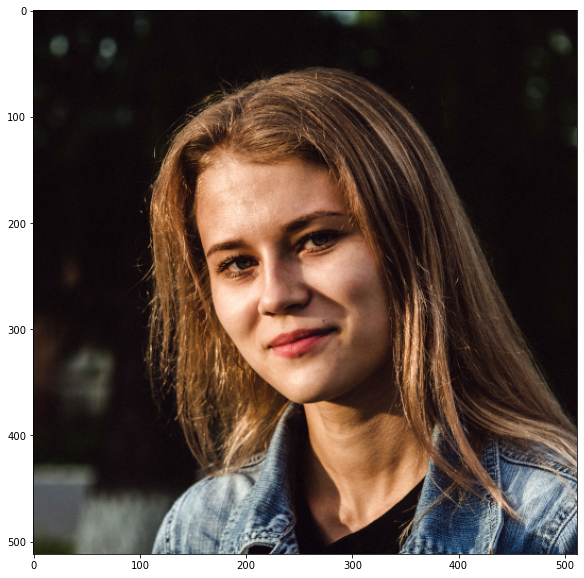

In [3]:
image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)

In [4]:
parser = FaceParser()
segmenter = FaceParsingSegmenter(parser)

In [5]:
parts_map = {
    "skin": 1,
    "l_eye": 2,
    "r_eye": 3,
    "hair": 4,
    "u_lip": 5,
    "l_lip": 5
}

In [6]:
segmented = segmenter.segment(np.expand_dims(image, 0), parts_map=parts_map).squeeze()

In [7]:
def show_colors(extractor, image, segmented, parts_map, title=""):
    colors = {part: extractor.extract(image, segmented == parts_map[part]) for part in parts_map}
    
    n_columns = 3
    n_colors = len(colors)
    n_rows = math.ceil(n_colors/n_columns)
    scale = 3

    fig, axs = plt.subplots(n_rows, n_columns, sharex=True, sharey=True, figsize=(n_columns*scale,n_rows*scale))

    for i, (part, color) in enumerate(colors.items()):
        r,c = divmod(i, n_columns)
        if color is None:
            axs[r,c].title.set_text("{} (not recognized)".format(part))
        else:
            axs[r,c].title.set_text(part)
            axs[r,c].imshow(color.reshape((1,1,3)))
    plt.suptitle(title)

In [8]:
out_parts_map = {
    "face": 1,
    "left eye": 2,
    "right eye": 3,
    "hair": 4,
    "lips": 5
}

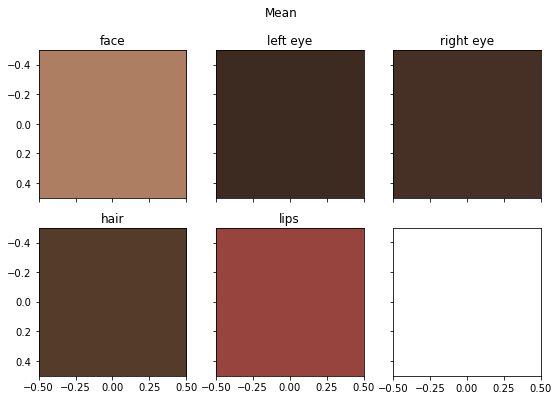

In [9]:
show_colors(extract.MeanColorExtractor(), image, segmented, out_parts_map, title="Mean")

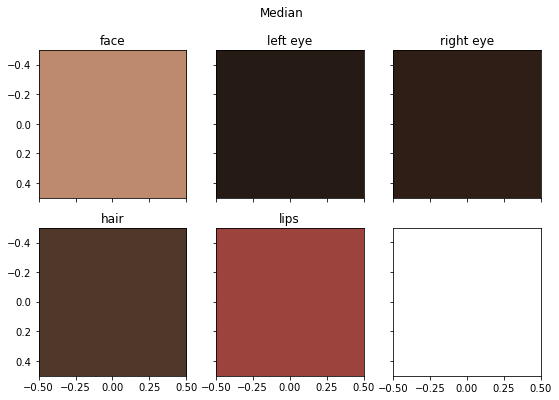

In [10]:
show_colors(extract.MedianColorExtractor(), image, segmented, out_parts_map, title="Median")

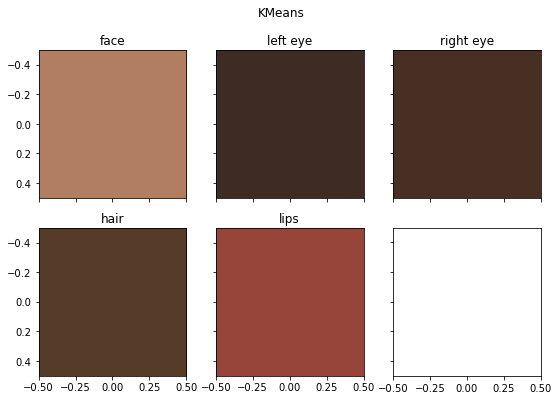

In [11]:
show_colors(extract.KMeansColorExtractor(), image, segmented, out_parts_map, title="KMeans")

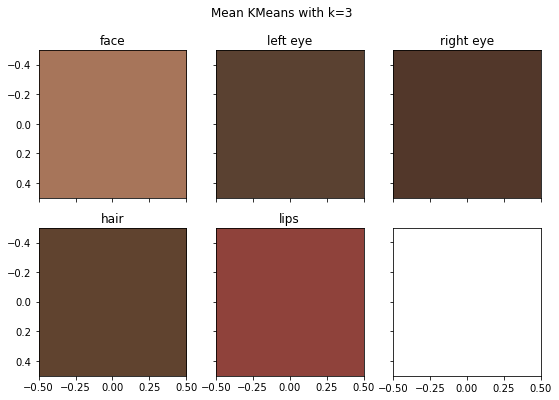

In [12]:
k=3
show_colors(extract.MeanKMeansColorExtractor(k=k), image, segmented, out_parts_map, title="Mean KMeans with k={}".format(k))